In [4]:
!pip install torchinfo

In [5]:
import os
import pathlib as path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import hashlib
import time
from PIL import Image
import cv2
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report

# Skin disease detection

Classification between 4/5 of skin diseases and an uninfected safe skin.

Methodology:

*   Images should be at a constant size and maybe apply transformations and rotations to increase bias.
*   Start off with a simple architecture maybe an AlexNet or other simple CNN designs and increase complexity from there.
*   CV search of more complex models.
*   hyperparam tuning of the best models.
*   consider ensembling if computaiton allow.

So let's start off by downloading the data and storing it in the right folders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# root = '/content/drive/MyDrive/skinDiseaseData'

!unzip "/content/drive/MyDrive/skinDiseaseData.zip" -d "/content"

# Input Image Processing

Our file structure has different class folders containing images. These folders are distributed in both train and test directories. For now only a small number of classes are present but the idea of the structure is the same:

-- root
* -- train
  * acne
  * eckzema
* -- test
  * acne
  * eckzema

We will use Datasets and DataLoaders to transform the data and make the inputs of our neural networks.

It should be a tensor of images and labels of size (batch, channels, height, width) and (batch) or (batch, 1) respectively.

We will use the PIL library to read the images but other libs can be used like io and cv

A custom dataset might seem likely to maybe transform the data to what we want. Might possibly make 2 sets of image data one for grayscale and another color just to see if we can cut corners in computation.

We have to visualize the dataset and see if the images are loaded correctly with their labels and check for any inconsistencies

Imports:
* Dataset and DataLoader
* numpy
* path and os
* PIL

In [7]:
root = '/content/skinDiseaseData'
print(os.listdir(f"{root}/train"))
print(os.listdir(f"{root}/test"))

['eczema', 'acne', 'vitiligo']
['eczema', 'acne', 'vitiligo']


In [ ]:
# class Normaliize:
#   def __call__(self, image):
#     return transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])(image)


class ToTensor:
  def __call__(self, image):
    return transforms.ToTensor()(image)


class HistEqualization:

  def __init__(self, grayscale=False):
    self.grayscale = grayscale

  def __call__(self, image):
      if self.grayscale:
          image_np = np.array(image)  # Convert PIL Image to NumPy array
          image_np = cv2.equalizeHist(image_np)  # Apply equalization directly
          return image_np

      else:
          image_np = np.array(image)
          image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2YUV)  # Convert to YUV
          image_np[:, :, 0] = cv2.equalizeHist(image_np[:, :, 0])  # Equalize Y channel
          image_np = cv2.cvtColor(image_np, cv2.COLOR_YUV2RGB)  # Convert back to RGB

      return image_np


class AdaptiveHistEqualization:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)

    def __call__(self, image):
        image_np = np.array(image)  # Convert PIL Image to NumPy array
        if len(image_np.shape) == 2:  # Grayscale
            image_np = self.clahe.apply(image_np)
        else:  # Color
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
            image_np[:, :, 0] = self.clahe.apply(image_np[:, :, 0])
            image_np = cv2.cvtColor(image_np, cv2.COLOR_LAB2RGB)
        return image_np

In [ ]:
class SkinDiseasesDataset(Dataset):
    def __init__(self, classLabel, num_classes, root_dir, transform=None,grayscale=None, histEq=None):
        self.root_dir = root_dir # train or test directories should be the last directory in this path
        self.classLabel = torch.tensor(classLabel)
        self.image_paths = self._read_image_paths_and_labels() # calls a helper fn to read and store all image paths and labels
        self.transform = transform
        self.grayscale = grayscale
        self.histEq = histEq
        self.num_classes = num_classes

    def _read_image_paths_and_labels(self):
        image_paths = [] # we return this as a list of image paths

        for image_name in os.listdir(self.root_dir): # iterate through /content/skinDiseaseData/{train or test}/acne
              image_path = os.path.join(self.root_dir, image_name) # now we are at /content/skinDiseaseData/{train or test}/{class_name for eg. 'acne' or 'eckzema'}/{image_name.jpg or jepg or png}
              image_paths.append(image_path) # we got the image path we want so now we append the image path to images
              print(f"appended {image_path}")
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.grayscale:
          image = image.convert("L")
        else:
          image = image.convert('RGB')  # Ensure images are in RGB format

        if self.transform:
            image = self.transform(image)

        label = self.classLabel

        one_hot_label = torch.zeros(self.num_classes)
        one_hot_label[label] = 1

        return image, one_hot_label, image_path




In [ ]:
data = SkinDiseasesDataset

In [10]:
for number, disease in enumerate(os.listdir(f"{root}/train")):
  print(number)
  print(f"{root}/train/{disease}")

0
/content/skinDiseaseData/train/eczema
1
/content/skinDiseaseData/train/acne
2
/content/skinDiseaseData/train/vitiligo


In [13]:
oneH = torch.zeros(3)
print(oneH)
oneH[1] = 3
print(oneH)

tensor([0., 0., 0.])
tensor([0., 3., 0.])


In [ ]:
vitiligo_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    AdaptiveHistEqualization(),  # Apply AHE
    ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

acne_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    AdaptiveHistEqualization(),
    ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eczema_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    AdaptiveHistEqualization(),
    ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [ ]:
transformDict = {'vitiligo': vitiligo_train_transform, 'acne': acne_train_transform, 'eczema':eczema_train_transform}

def make_dataloader(root, transformDict):
  datasets = []
  labelsDict = {}
  num_classes = len(os.listdir(root))

  for label, className in enumerate(os.listdir(root)):
    dataset = SkinDiseasesDataset(root_dir=os.path.join(root, className),
                                  classLabel=label,
                                  num_classes=num_classes,
                                  transform=transformDict[className],
                                  )
    datasets.append(dataset)
    labelsDict[label] = className

  dataset = torch.utils.data.ConcatDataset(datasets)
  dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

  return dataset, dataloader

train_dataset, train_dataloader = make_dataloader(root=f"{root}/train", transformDict=transformDict)
test_dataset, test_dataloader = make_dataloader(root=f"{root}/test", transformDict=transformDict)

print(len(train_dataloader))
print(len(train_dataloader.dataset))
print(len(test_dataloader))
print(len(test_dataloader.dataset))


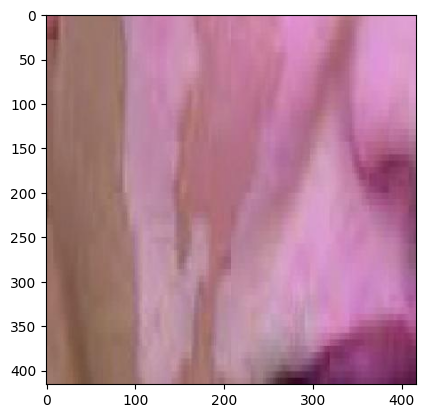

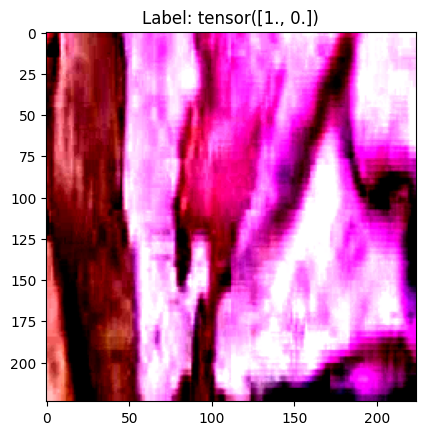

In [ ]:
import random
import matplotlib.pyplot as plt

for i, (images, labels, image_paths) in enumerate(train_dataloader):
    if i == 0:  # Get the first batch
        first_batch_images = images
        first_batch_labels = labels
        first_batch_image_paths = image_paths
        break  # Exit the loop after getting the first batch

# Now, 'first_batch_images' and 'first_batch_labels' contain the data from the first batch
# To get the first value (image and label) within the first batch:
first_image = first_batch_images[0]
first_label = first_batch_labels[0]
first_image_path = first_batch_image_paths[0]

real_image = Image.open(first_image_path)
plt.imshow(real_image)
plt.show()

# Display the image using matplotlib
plt.imshow(first_image.permute(1, 2, 0))  # Permute the dimensions to (height, width, channels
plt.title(f"Label: {first_label}")  # Display the label
plt.axis('on')  # Turn off axis ticks and labels
plt.show()

In [ ]:
from torch.utils.data import Subset

# This is a smaller part of the training dataset for overfit check
small_dataset = torch.utils.data.Subset(train_dataset, indices=range(1500))  # Select a small number of samples (e.g., 100)
small_dataloader = DataLoader(small_dataset, batch_size=32, shuffle=True)
print(len(small_dataloader))
print(len(small_dataloader.dataset))
print(len(train_dataloader))
print(len(train_dataloader.dataset))
print(len(test_dataloader))
print(len(test_dataloader.dataset))

47
1500
125
3989
22
690


# Utility functions

In [ ]:
def record_training_time(func):
    '''
      A decorator function that takes another function and records the time it take to run
    '''
    def wrapper(*args, **kwargs):

        start_time = time.time() # start timer

        results = func(*args, **kwargs) # run function

        end_time = time.time() # end timer

        training_time = end_time - start_time # find the difference
        training_time /= 60.0

        # print(f"Training time: {training_time:.2f} seconds")

        return results, training_time  # Return training time along with other results
    return wrapper

def cache_training_results(cache_dir="training_cache"):
    '''
      A decorator function that saves the results of a model in training incase during training loop
      we run a model more than once during hyperparam tuning for eg. so we return the saved results instead of recomputing
    '''
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Create cache directory if it doesn't exist
            os.makedirs(cache_dir, exist_ok=True)

            # Generate cache key based on function arguments
            cache_key_bytes = pickle.dumps((args, tuple(sorted(kwargs.items()))))

            # Calculate hash of serialized bytes using hashlib
            cache_key = hashlib.md5(cache_key_bytes).hexdigest()

            # Check if results are already cached
            cache_path = os.path.join(cache_dir, f"{hash(cache_key)}.pkl")
            if os.path.exists(cache_path):
                with open(cache_path, "rb") as f:
                    print(f"Loading cached results from {cache_path}")
                    return pickle.load(f)

            # Run training loop and cache results
            results = func(*args, **kwargs)
            with open(cache_path, "wb") as f:
                pickle.dump(results, f)

            return results
        return wrapper
    return decorator

In [ ]:
def plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies):
    '''
      plots the losses and accuracies passed toghether respectively in one plot for inference and comparison.

      Args:
        train_losses (list): train losees from training loop
        train_accuracies (list): train accuracies from training loop
        test_losses (list): test losses from testing loop which is returned by the training loop
        test_losses (list): test accuracies from testing loop which is returned by the training loop

      Returns: None
    '''
    epochs = range(len(train_losses))  # Get the number of epochs

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.xlim(0, len(epochs))  # Set x-axis limit to the number of epochs
    plt.ylim(0, 1)  # Set y-axis limit to 1.1 times the maximum loss
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlim(0, len(epochs))  # Set x-axis limit to the number of epochs
    plt.ylim(0, 1)  # Set y-axis limit to 1.1 times the maximum accuracy
    plt.legend()

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

def plot_training_history_multiple(runs_history):
    plt.figure(figsize=(12, 8))

    # Group data by metric
    all_train_accuracies = [history['train_accuracies'][-1] for history in runs_history.values()]
    all_test_accuracies = [history['test_accuracies'][-1] for history in runs_history.values()]
    all_train_losses = [history['train_losses'][-1] for history in runs_history.values()]
    all_test_losses = [history['test_losses'][-1] for history in runs_history.values()]

    # Get parameter labels
    param_labels = [str(params) for params in runs_history.keys()]

    # Plot accuracies
    plt.subplot(2, 1, 1)  # Accuracy subplot
    plt.bar(param_labels, all_train_accuracies, label='Train Accuracy')
    plt.bar(param_labels, all_test_accuracies, label='Test Accuracy')
    plt.ylabel("Accuracy")
    plt.title("Training and Test Accuracy Across Hyperparameter Configurations")
    plt.legend()
    plt.grid(True)

    # Plot losses
    plt.subplot(2, 1, 2)  # Loss subplot
    plt.bar(param_labels, all_train_losses, label='Train')
    plt.bar(param_labels, all_test_losses, label='Test Loss')
    plt.ylabel("Loss")
    plt.title("Training and Test Loss Across Hyperparameter Configurations")
    plt.legend()
    plt.grid(True)

    plt.suptitle("Training History Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
@record_training_time
# @cache_training_results()
def training_loop(epochs, dataloader, model, loss_fn, optimizer, device, verbose=False, patience=5):
    '''
      Executes the training process for a specified number of epochs, tracks performance metrics,
      and evaluates the model using a testing loop after each epoch.

      Args:
        epochs (int): The number of training epochs.
        dataloader (DataLoader): The DataLoader for the training dataset, providing batches of data.
        model (nn.Module): The PyTorch model to be trained.
        loss_fn (nn.Module): The loss function to optimize (e.g., CrossEntropyLoss or BCELoss).
        optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters (e.g., AdamOtimpizer or SGD).
        device (torch.device): The computation device ('cpu' or 'cuda') for running the training process.
        verbose (bool, optional): If True, prints detailed progress during training.

      Returns:
          tuple: A tuple containing four lists:
              - train_losses (list): The training loss for each epoch.
              - train_accuracies (list): The training accuracy for each epoch.
              - test_losses (list): The testing loss for each epoch.
              - test_accuracies (list): The testing accuracy for each epoch.
    '''

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    size = len(dataloader.dataset)
    best_test_accuracy = float('-inf')
    epochs_no_improve = 0
    for epoch in range(epochs):
        train_loss = 0
        accuracy = 0
        model.train()
        for batch, (X, y, _) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            pred = model(X)
            # pred = nn.Softmax(dim=1)(pred)

            print(pred)
            print(y)
            loss = loss_fn(pred, y)
            train_loss += loss.item()
            accuracy += (torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)).type(torch.float).sum().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if verbose:
              if batch % 50 == 0:
                print(f"looked at {(batch+1)*len(X)}/{size} at epoch{epoch}...")
        train_loss /= size
        accuracy /= size
        if verbose:
          print(f"epoch: {epoch+1} | train_loss: {train_loss:.3f} | accuracy: {accuracy:.3f}")
        train_losses.append(train_loss)
        train_accuracies.append(accuracy)

        # testing loop
        test_loss, test_accuracy = testing_loop(test_dataloader, model, loss_fn, device)
        if verbose:
          print(f"test_loss: {test_loss} | accuracy: {test_accuracy}")
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after epoch {epoch + 1}")
                break

    return train_losses, train_accuracies, test_losses, test_accuracies


def testing_loop(dataloader, model, loss_fn, device):
    '''
      Executes the testing process and tracks performance metrics. It is meant to be run in the training loop function
      in order to save multiple losses and accuracies for plotting and visualisation.

      Args:
        dataloader (DataLoader): The DataLoader for the training dataset, providing batches of data.
        model (nn.Module): The PyTorch model to be trained.
        loss_fn (nn.Module): The loss function to optimize (e.g., CrossEntropyLoss or BCELoss).
        device (torch.device): The computation device ('cpu' or 'cuda') for running the training process.


      Returns:
          tuple: A tuple containing 2 values:
              - test_loss (int): the average loss across all batches
              - test_accuracy (int): the average accuracy across all batches
    '''
    size = len(dataloader.dataset)
    test_loss, test_accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
      for batch, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        # predictions = nn.Softmax(dim=1)(pred)
        predicted_labels = torch.argmax(pred, dim=1)
        true_labels = torch.argmax(y, dim=1)

        test_loss += loss_fn(pred, y).item()
        test_accuracy += (predicted_labels == true_labels).type(torch.float).sum().item()

    test_loss /= size
    test_accuracy /= size
    return test_loss, test_accuracy


def overfit_check(epochs, dataloader, model, loss_fn, optimizer, device):
      '''
        Performs a check whether the model is capable of overfitting data. It is recommended to use small subsets of training
        data to use in this funtion.

        Args:
          epochs (int): The number of training epochs.
          dataloader (DataLoader): The DataLoader for the training dataset, providing batches of data.
          model (nn.Module): The PyTorch model to be trained.
          loss_fn (nn.Module): The loss function to optimize (e.g., CrossEntropyLoss or BCELoss).
          optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters (e.g., AdamOtimpizer or SGD).
          device (torch.device): The computation device ('cpu' or 'cuda') for running the training process.

        Returns: None
      '''
      model.train()
      for epoch in range(epochs):
          train_loss = 0
          accuracy = 0
          for batch, (X, y, _) in enumerate(dataloader):

              X, y = X.to(device), y.to(device)

              pred = model(X)
              loss = loss_fn(pred, y)
              train_loss += loss.item()

              accuracy += (torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)).type(torch.float).sum().item()

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

          train_loss /= len(dataloader.dataset)  # Calculate average loss
          accuracy /= len(dataloader.dataset)    # Calculate average accuracy
          print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}")

          if accuracy > 0.99:
              print("Overfitting detected! Stopping early.")
              break

In [ ]:
def create_optimizer(optimizerClass, model_params, hyper_params):
    return optimizerClass(model_params, **hyper_params)

def reinitialize_model(model):
       print("reinitializing...")
       for layer in model.children():
           if hasattr(layer, 'reset_parameters'):
               layer.reset_parameters()
               print("done.")
           else:
               reinitialize_model(layer)

def train_model(epochs, model, params, loss_fn, optimizerClass, dataloader):
    '''
      trains model with the hyperparameter, loss function and optimizer class passed. the create_model()
      will be tweaked to change model but for now we just manually change it :p.

      Args:
        params (dict): a dictionary of hyperparameters and it's values that should be used
        loss_fn (nn.Module): a loss funtion to be used to compute losses
        optimizer (torch.optim.Optimizer): optimizer funtion to be used
        dataloader (torch.utils.data.dataloader): the training data
    '''

    print(f"Training with parameters: {params}")

    reinitialize_model(model)

    # implicit creation of a loss function although it looks like I'll just spam Adam optimizer :)
    optimizer = create_optimizer(optimizerClass, model.parameters(), params)

    (train_losses, train_accuracies, test_losses, test_accuracies), training_time = training_loop(
        epochs=epochs,
        dataloader=dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        patience=8)

    plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies)

    # Evaluate the model
    test_loss, test_accuracy = test_losses[-1], test_accuracies[-1]
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Training time: {training_time:.2f} minute(s)", end="\n\n---------------------------\n")

    # Return results for evaluation
    return {
        "params": params,
        "score": test_accuracy,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
        "training_time": training_time
    }

In [ ]:
def evaluate_model(model, dataloader, device):
  """
  Evaluates the model and generates a classification report.

  Args:
    model: The trained PyTorch model.
    dataloader: The DataLoader for the dataset (test or validation).
    device: The device to run the model on ('cpu' or 'cuda').

  Returns:
    None (Prints the classification report)
  """

  model.eval()  # Set the model to evaluation mode
  all_predictions = []
  all_labels = []

  with torch.no_grad():  # Disable gradient computation during inference
    for images, labels, _ in dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)  # Get predicted class labels
      all_predictions.extend(predicted.cpu().numpy())
      all_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Get true labels

  # Generate and print the classification report
  report = classification_report(all_labels, all_predictions)
  print(report)

In [ ]:
inputChannels = 3
numClasses = 3

In [ ]:
!nvidia-smi

Wed Apr  9 12:35:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             33W /   70W |    2390MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Simple CNN architecture

let us start off with a simple cnn structure with 2 cnns, 2 maxpooling, 2 batchnorms, 2 fully connected layers.

This alone for 2 classes is already almost overfitting so tuning had to be made to increase bias, however for 3 classes it has reached a plateu of aroung 93% accuracy on the test dataset.

Best Parameters: {betas: (0.9, 0.999), eps: 1e-08, lr: 0.001,weight_decay: 0.0}
Best Score: 0.9259259259259259

below is the classification report of the best model from param search.

                precision    recall  f1-score   support

       eczema       0.94      0.86      0.90       309
     vitiligo       0.89      1.00      0.94       368
         acne       0.86      0.81      0.83       322

    accuracy                            0.89       999
    macro avg       0.90       0.89     0.89       999
    weighted avg    0.89       0.89     0.89       999


It seems this CNN is predicting alot of classes as vitiligo for some reason maybe due to some similarities with a type of eczema where it turns patches of skin white. So either a more complex net will be needed to overcome this or an image processing of some sort. It is more strict at predicting eczema but when it does say the problem is eczema it gets it right 94% of the time. As for acne it's having a pretty hard time idetifying it surprisingly. I thought it was the most obvious one to find



In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, inputChannels, num_classes):
        super(SimpleCNN, self).__init__()
        self.inputChannels = inputChannels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(self.inputChannels, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Adjust input size based on your image dimensions
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, self.num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)  # Adjust flattening based on your image dimensions
        x = self.dropout(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
simpleCNN= SimpleCNN(inputChannels=inputChannels, num_classes=numClasses)
for name, param in simpleCNN.named_parameters():
    print(name, param.shape)
summary(simpleCNN, input_size=(1, 3, 227, 227))

conv1.weight torch.Size([16, 3, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([32, 16, 3, 3])
conv2.bias torch.Size([32])
fc1.weight torch.Size([128, 100352])
fc1.bias torch.Size([128])
fc2.weight torch.Size([3, 128])
fc2.bias torch.Size([3])


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 3]                    --
├─Conv2d: 1-1                            [1, 16, 227, 227]         448
├─ReLU: 1-2                              [1, 16, 227, 227]         --
├─MaxPool2d: 1-3                         [1, 16, 113, 113]         --
├─Conv2d: 1-4                            [1, 32, 113, 113]         4,640
├─ReLU: 1-5                              [1, 32, 113, 113]         --
├─MaxPool2d: 1-6                         [1, 32, 56, 56]           --
├─Dropout: 1-7                           [1, 100352]               --
├─Linear: 1-8                            [1, 128]                  12,845,184
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 3]                    387
Total params: 12,850,659
Trainable params: 12,850,659
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 95.18
Input size (MB): 0.62
F

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam

param_grid = {
    'lr': [1e-2, 1e-3, 1e-4],  # Learning rates
    'eps': [1e-7, 1e-8],  # Epsilon values
    'weight_decay': [0.0],  # Weight decay
    'amsgrad': [True],  # Amsgrad
    'betas': [(0.9, 0.999)]  # Betas
}

grid = ParameterGrid(param_grid)

results = [train_model(10, simpleCNN, params, loss_fn, optimizer, train_dataloader) for i, params in enumerate(grid)]

# Find the best configuration
best_result = max(results, key=lambda r: r["score"])
print(f"Best Parameters: {best_result['params']}")
print(f"Best Score: {best_result['score']}")

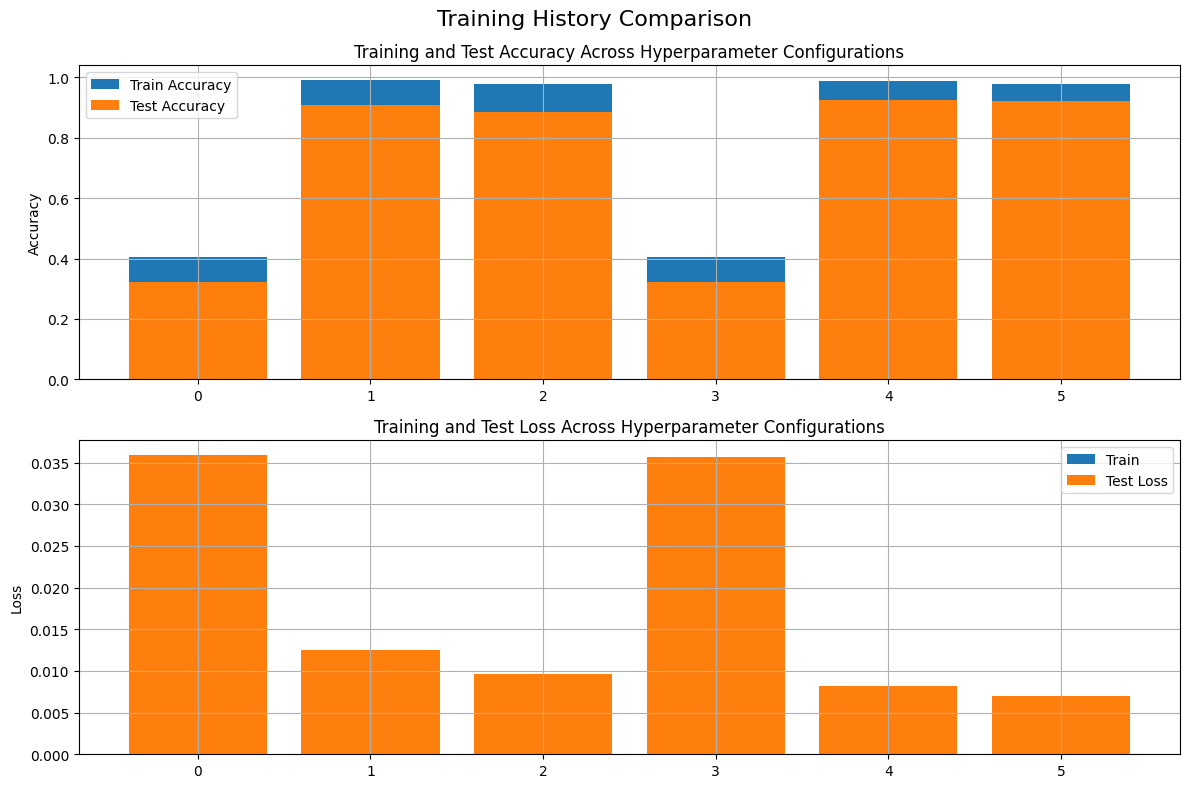

In [ ]:
plot_training_history_multiple({i: result for i, result in enumerate(results)})

In [ ]:
# Best Parameters: {'betas': (0.9, 0.999), 'eps': 1e-08, 'lr': 0.001, 'weight_decay': 0.0}
# Best Score: 0.9259259259259259

best_optimizer = optim.Adam(simpleCNN.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0
)
best_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
(train_losses, train_accuracies, test_losses, test_accuracies), training_time = training_loop(
    epochs=30,
    dataloader=train_dataloader,
    model=simpleCNN,
    loss_fn=loss_fn,
    optimizer=best_optimizer,
    device=device,
    verbose=True,
    patience=9)

print(f"Training time: {training_time:.2f} minute(s)")
evaluate_model(simpleCNN, test_dataloader, device)

looked at 32/5224 at epoch0...
looked at 1632/5224 at epoch0...
looked at 3232/5224 at epoch0...
looked at 4832/5224 at epoch0...
epoch: 1 | train_loss: 0.013 | accuracy: 0.815
test_loss: 0.014113280359092538 | accuracy: 0.8118118118118118
looked at 32/5224 at epoch1...
looked at 1632/5224 at epoch1...
looked at 3232/5224 at epoch1...
looked at 4832/5224 at epoch1...
epoch: 2 | train_loss: 0.009 | accuracy: 0.880
test_loss: 0.01118549616546841 | accuracy: 0.8568568568568569
looked at 32/5224 at epoch2...
looked at 1632/5224 at epoch2...
looked at 3232/5224 at epoch2...
looked at 4832/5224 at epoch2...
epoch: 3 | train_loss: 0.005 | accuracy: 0.939
test_loss: 0.00902548621970791 | accuracy: 0.8878878878878879
looked at 32/5224 at epoch3...
looked at 1632/5224 at epoch3...
looked at 3232/5224 at epoch3...
looked at 4832/5224 at epoch3...
epoch: 4 | train_loss: 0.003 | accuracy: 0.971
test_loss: 0.014230868300876102 | accuracy: 0.8758758758758759
looked at 32/5224 at epoch4...
looked at 1

# VGG architecture

It is a typical deep Convolutional Neural Network (CNN) design with numerous layers, and the abbreviation VGG stands for Visual Geometry Group. The term “deep” describes the number of layers, with VGG-16 or VGG-19 having 16 or 19 convolutional layers, respectively.

Very tiny convolutional filters are used in the construction of the VGG network. Thirteen convolutional layers and three fully connected layers make up the VGG-16.

Let’s quickly examine VGG’s architecture:

* **Inputs**: The VGGNet accepts 224224-pixel images as input. To maintain a consistent input size for the ImageNet competition, the model’s developers chopped out the central 224224 patches in each image.

* **Convolutional Layers**: VGG’s convolutional layers use the smallest feasible receptive field, or 33, to record left-to-right and up-to-down movement. Additionally, 11 convolution filters are used to transform the input linearly.
The next component is a ReLU unit, a significant advancement from AlexNet that shortens training time. Rectified linear unit activation function, or ReLU, is a piecewise linear function that, if the input is positive, outputs the input; otherwise, the output is zero. The convolution stride is fixed at 1 pixel to keep the spatial resolution preserved after convolution (stride is the number of pixel shifts over the input matrix).

* **Hidden Layers**: The VGG network’s hidden layers all make use of ReLU. Local Response Normalization (LRN) is typically not used with VGG as it increases memory usage and training time. Furthermore, it doesn’t increase overall accuracy.

* **Fully Connected Layers**: The VGGNet contains three layers with full connectivity. The first two levels each have 4096 channels, while the third layer has 1000 channels with one channel for each class.

In [ ]:
class VGGNet(nn.Module):
  def __init__(self, inputChannels, num_classes):
    super(VGGNet, self).__init__()
    self.inputChannels = inputChannels
    self.num_classes = num_classes

    self.conv1 = nn.Sequential(
        nn.Conv2d(self.inputChannels, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.conv4 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.conv5 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.fullyConnected = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(256 * 7 * 7, 4096),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, self.num_classes)
        )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = x.view(-1, 256 * 7 * 7)
    x = self.fullyConnected(x)
    return x

In [ ]:
inputChannels = 3
numClasses = 3

vggNet = VGGNet(inputChannels=inputChannels, num_classes=numClasses).to(device)
summary(vggNet, input_size=(1, inputChannels, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet                                   [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 32, 112, 112]         --
├─Sequential: 1-2                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-4                       [1, 64, 112, 112]         18,496
│    └─ReLU: 2-5                         [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-6                    [1, 64, 56, 56]           --
├─Sequential: 1-3                        [1, 128, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 128, 56, 56]          73,856
│    └─ReLU: 2-8                         [1, 128, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 128, 56, 56]          147,584
│

In [ ]:
device

'cuda'

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam

param_grid = {
    'lr': [1e-2, 1e-3, 1e-4],  # Learning rates
    'eps': [1e-7, 1e-8],  # Epsilon values
    'weight_decay': [0.0],  # Weight decay
    'amsgrad': [False, True],  # Amsgrad
    'betas': [(0.9, 0.999)]  # Betas
}

grid = ParameterGrid(param_grid)

results = [train_model(10, vggNet, params, loss_fn, optimizer, train_dataloader) for i, params in enumerate(grid)]

best_result = max(results, key=lambda r: r["score"])
print(f"Best Parameters: {best_result['params']}")
print(f"Best Score: {best_result['score']}")

Training with parameters: {'amsgrad': False, 'betas': (0.9, 0.999), 'eps': 1e-07, 'lr': 0.01, 'weight_decay': 0.0}
reinitializing...
reinitializing...
done.
reinitializing...
reinitializing...
reinitializing...
done.
reinitializing...
reinitializing...
reinitializing...
done.
reinitializing...
done.
reinitializing...
reinitializing...
reinitializing...
done.
reinitializing...
done.
reinitializing...
reinitializing...
reinitializing...
done.
reinitializing...
done.
reinitializing...
reinitializing...
reinitializing...
reinitializing...
done.
reinitializing...
reinitializing...
done.
reinitializing...
done.
tensor([[ 5.8101e-03,  2.0676e-04, -9.6402e-03],
        [ 5.9318e-03,  1.1740e-03, -9.8181e-03],
        [ 7.8280e-03, -4.0063e-06, -9.8328e-03],
        [ 5.1993e-03,  1.8582e-03, -9.9617e-03],
        [ 4.0740e-03,  1.3630e-03, -9.2564e-03],
        [ 3.9948e-03, -1.3975e-03, -9.1591e-03],
        [ 4.7131e-03,  1.9494e-03, -7.1086e-03],
        [ 7.1880e-03,  6.4409e-04, -7.2655e-

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
plot_training_history_multiple({i: result for i, result in enumerate(results)})

# AlexNet architecture

This CNN architechture consists of 5 convolution layers, 3 max-pooling layers, 2 Normalized layers, 2 fully connected layers and 1 softmax layer.

The structure is as follows:
* Conv2D: input - (227,227, 3), depth - 96, kernel - (11, 11), stride - 4 activation - ReLu, output - (55, 55, 96)

* MaxPooling2D: input - (55,55, 96), kernel - (3, 3), stride - 4, activation - ReLu, output - (27, 27, 96)

* Normalization

* Conv2D: input - (27, 27, 96), depth - 256, kernel - (5, 5), stride - 1, padding - 2, activation - ReLu, output - (27, 27, 256)

* MaxPooling2D: input - (27, 27, 256), kernel - (3, 3), stride - 2,
activation - ReLu, output - (13, 13, 256)

* Normalization

* Conv2D: input - (13, 13, 256), depth - 384, kernel - (3, 3), stride - 1,
padding - 1, activation - ReLu, output - (13, 13, 384)

* Conv2D: input - (13, 13, 384), depth - 384, kernel - (3, 3), stride - 1,
padding - 1, activation - ReLu, output - (13, 13, 384)

* Conv2D: input - (13, 13, 384), depth - 256, kernel - (3, 3), stride - 1,
padding - 1, activation - ReLu, output - (13, 13, 256)

* MaxPooling2D: input - (13, 13, 256), kernel - (3, 3), stride - 2,
activation - ReLu, output - (6, 6, 256)

* Flatten

* Dropout

* FullyConnectedLayer: input - (256 * 6 * 6), output - (4096), activation - ReLu

* Dropout

* FullyConnectedLayer: input - (4096), output - (4096), activation - ReLu

* FullyConnectedLayer: input - (4096), output - (classes), activation - ReLu

* Softmax: input - (classes), output - (logits)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, inputChannels, num_classes):
        super(AlexNet, self).__init__()
        self.num_classes = num_classes
        self.inputChannels = inputChannels
        self.conv_base = nn.Sequential(
            nn.Conv2d(self.inputChannels, 96, kernel_size=11, stride=4, padding=2, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fc_base = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, self.num_classes),
        )

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), 256*6*6)
        x = self.fc_base(x)
        return x

In [ ]:
# Assuming your model is named 'cnnAlex' and input size is (3, 227, 227)
cnnAlex = AlexNet(input_size=inputChannels, num_classes=numClasses).to(device)
summary(cnnAlex, input_size=(1, inputChannels, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 96, 56, 56]           34,848
│    └─BatchNorm2d: 2-2                  [1, 96, 56, 56]           192
│    └─ReLU: 2-3                         [1, 96, 56, 56]           --
│    └─MaxPool2d: 2-4                    [1, 96, 27, 27]           --
│    └─Conv2d: 2-5                       [1, 256, 27, 27]          614,400
│    └─BatchNorm2d: 2-6                  [1, 256, 27, 27]          512
│    └─ReLU: 2-7                         [1, 256, 27, 27]          --
│    └─MaxPool2d: 2-8                    [1, 256, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 384, 13, 13]          885,120
│    └─ReLU: 2-10                        [1, 384, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 384, 13, 13]          1,

Training with parameters: {'amsgrad': False, 'eps': 1e-08, 'lr': 0.001}
Training time: 24129.60 seconds


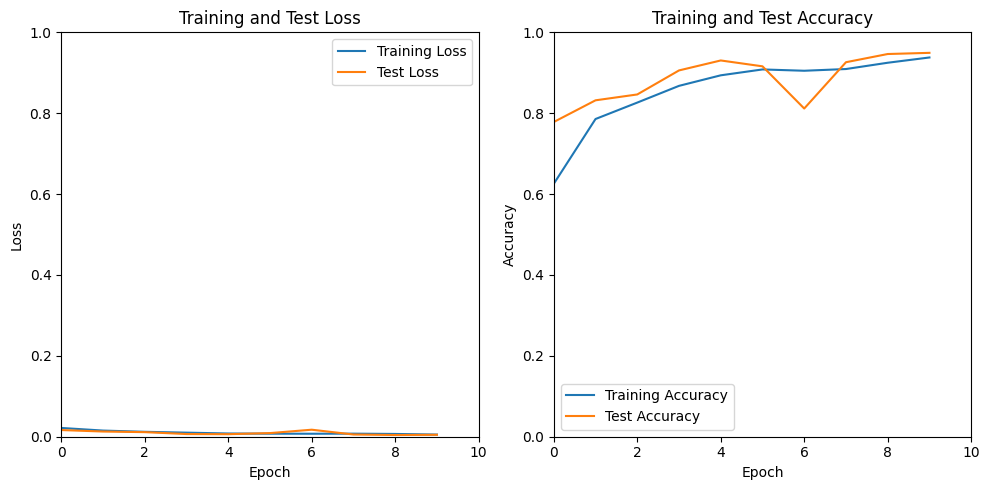

Test Loss: 0.0047, Test Accuracy: 0.9493
Training time: 24129.60 minute(s)
Training with parameters: {'amsgrad': False, 'eps': 1e-08, 'lr': 0.0001}
Training time: 23842.75 seconds


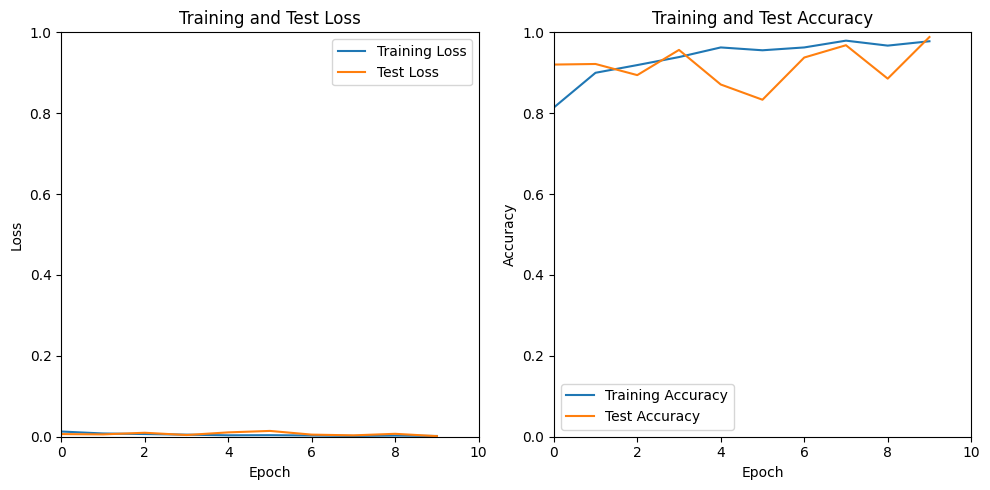

Test Loss: 0.0014, Test Accuracy: 0.9884
Training time: 23842.75 minute(s)
Training with parameters: {'amsgrad': False, 'eps': 1e-08, 'lr': 1e-05}
Training time: 24081.99 seconds


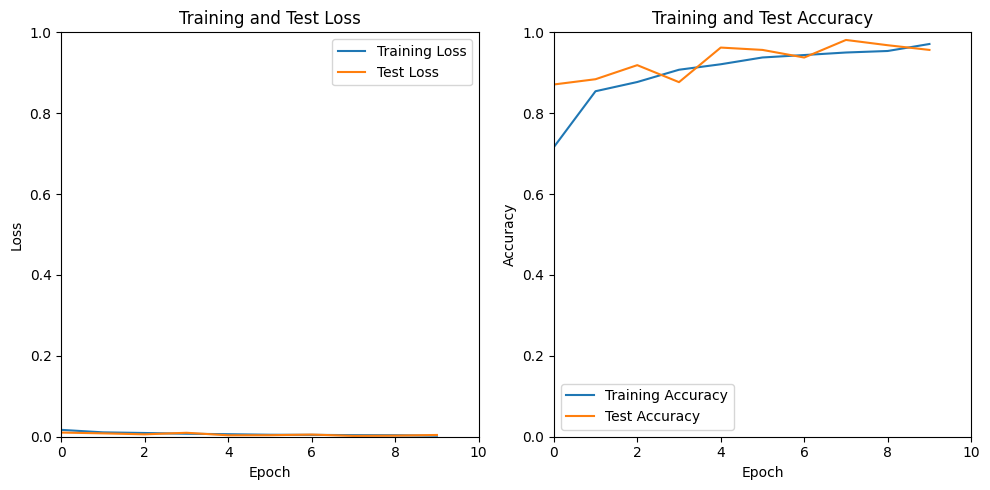

Test Loss: 0.0043, Test Accuracy: 0.9565
Training time: 24081.99 minute(s)
Training with parameters: {'amsgrad': False, 'eps': 1e-07, 'lr': 0.001}
Training time: 23799.49 seconds


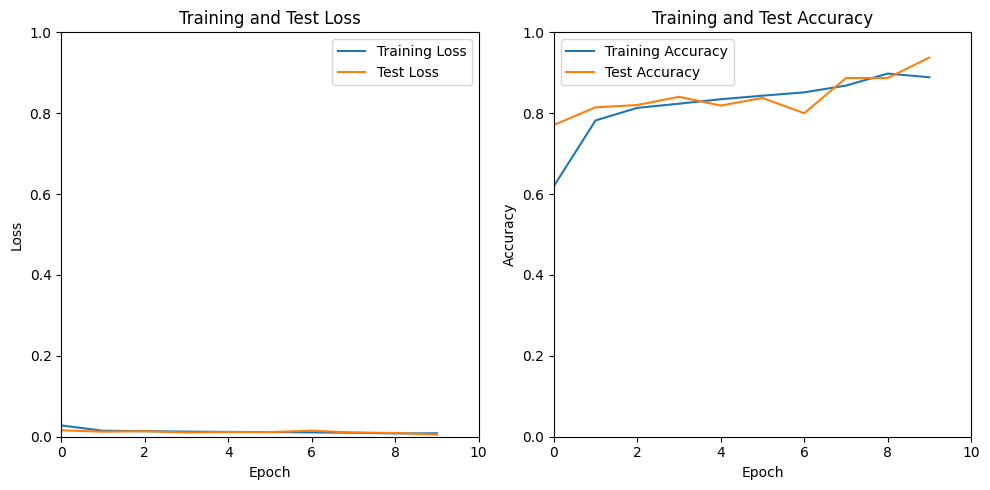

Test Loss: 0.0052, Test Accuracy: 0.9377
Training time: 23799.49 minute(s)
Training with parameters: {'amsgrad': False, 'eps': 1e-07, 'lr': 0.0001}
Training time: 23803.21 seconds


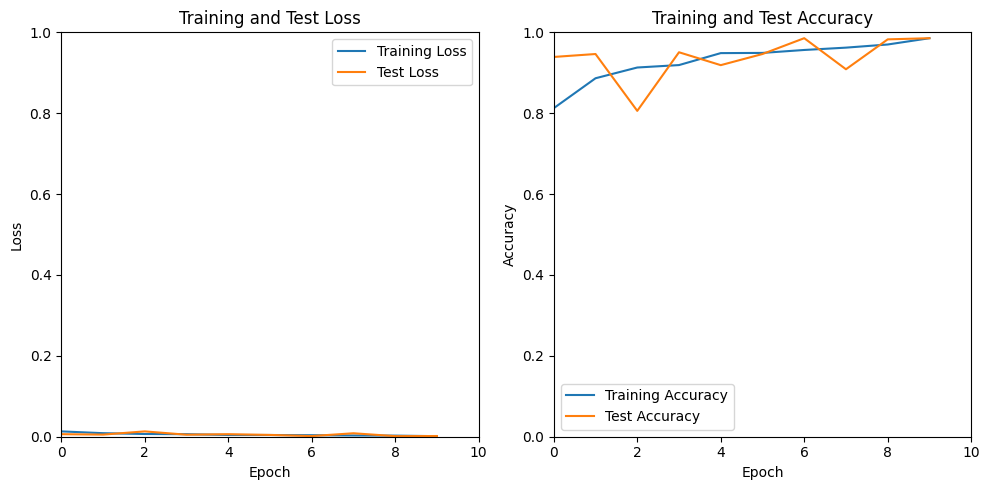

Test Loss: 0.0017, Test Accuracy: 0.9855
Training time: 23803.21 minute(s)
Training with parameters: {'amsgrad': False, 'eps': 1e-07, 'lr': 1e-05}
Training time: 24133.54 seconds


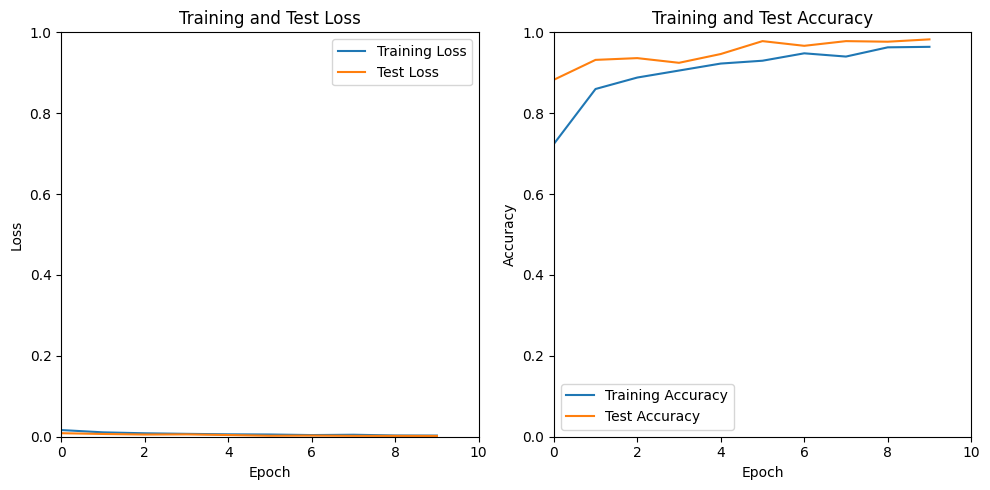

Test Loss: 0.0019, Test Accuracy: 0.9826
Training time: 24133.54 minute(s)
Training with parameters: {'amsgrad': True, 'eps': 1e-08, 'lr': 0.001}
Training time: 23796.15 seconds


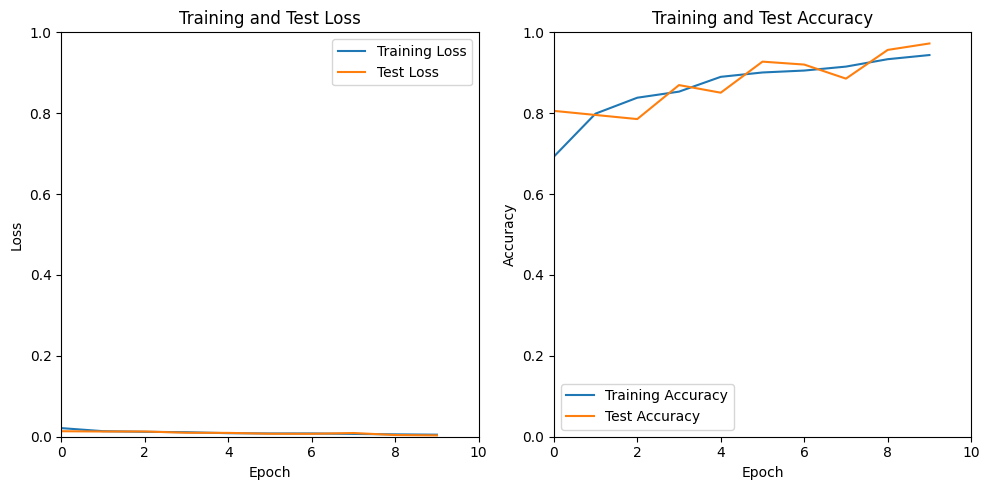

Test Loss: 0.0033, Test Accuracy: 0.9725
Training time: 23796.15 minute(s)
Training with parameters: {'amsgrad': True, 'eps': 1e-08, 'lr': 0.0001}
Training time: 23879.17 seconds


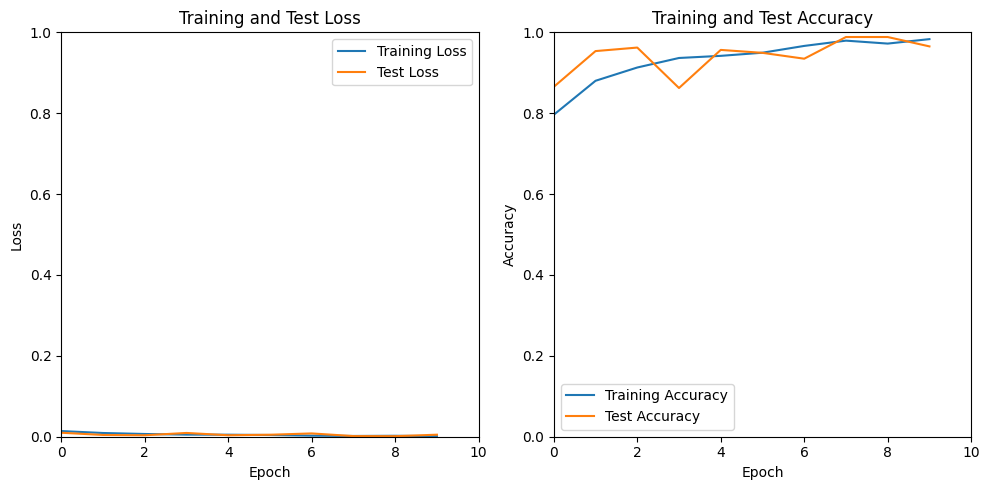

Test Loss: 0.0050, Test Accuracy: 0.9652
Training time: 23879.17 minute(s)
Training with parameters: {'amsgrad': True, 'eps': 1e-08, 'lr': 1e-05}
Training time: 23953.07 seconds


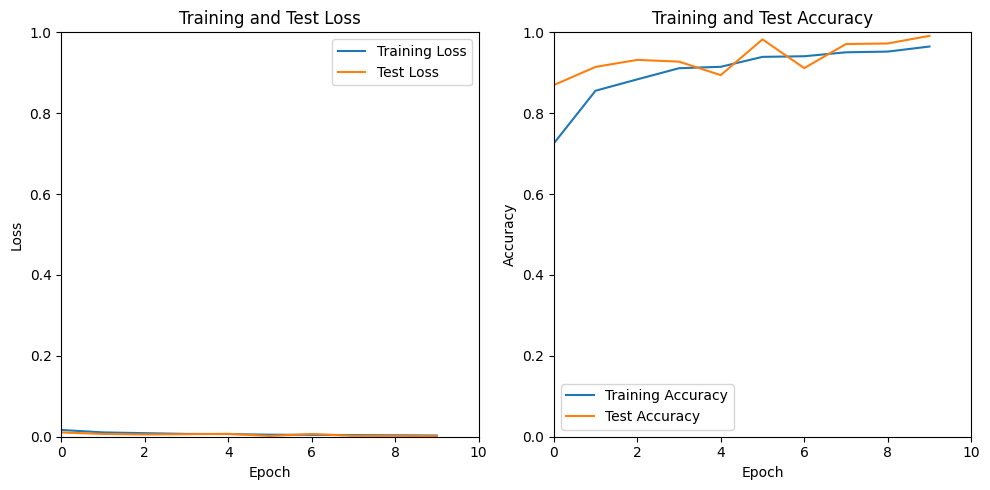

Test Loss: 0.0015, Test Accuracy: 0.9913
Training time: 23953.07 minute(s)
Training with parameters: {'amsgrad': True, 'eps': 1e-07, 'lr': 0.001}
Training time: 24049.92 seconds


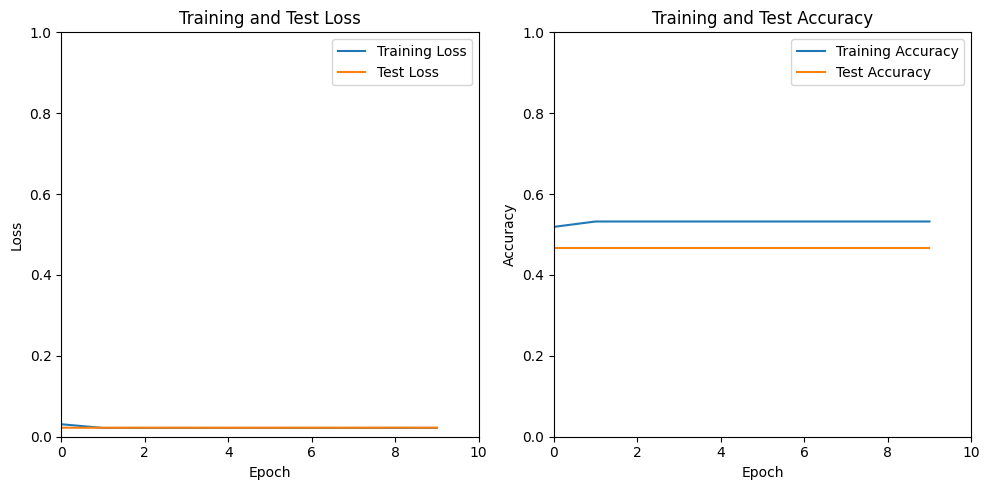

Test Loss: 0.0224, Test Accuracy: 0.4667
Training time: 24049.92 minute(s)
Training with parameters: {'amsgrad': True, 'eps': 1e-07, 'lr': 0.0001}
Training time: 24166.74 seconds


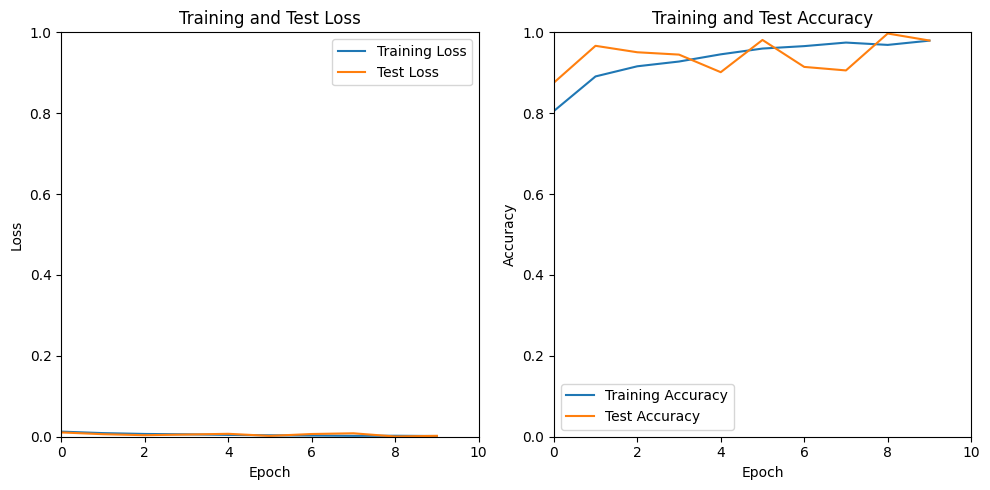

Test Loss: 0.0022, Test Accuracy: 0.9797
Training time: 24166.74 minute(s)
Training with parameters: {'amsgrad': True, 'eps': 1e-07, 'lr': 1e-05}
Training time: 23916.35 seconds


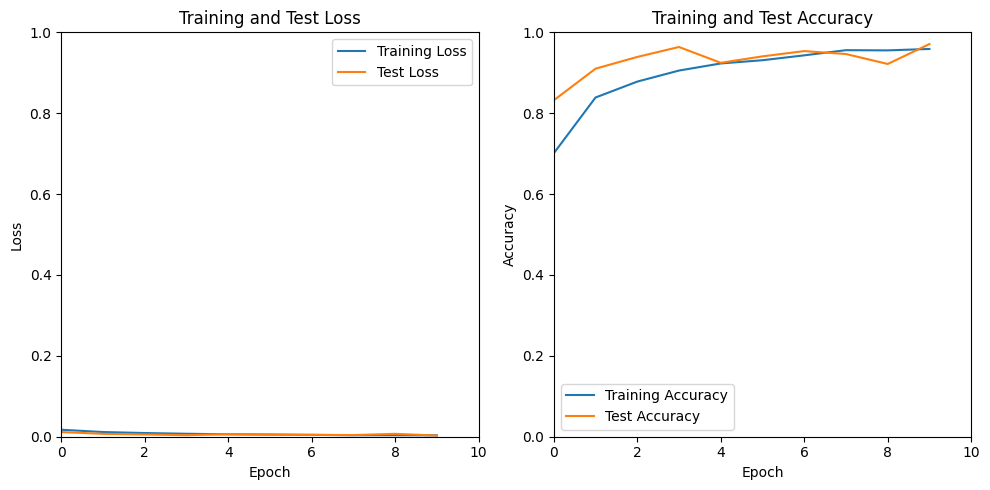

Test Loss: 0.0028, Test Accuracy: 0.9710
Training time: 23916.35 minute(s)
Best Parameters: {'amsgrad': True, 'eps': 1e-08, 'lr': 1e-05}
Best Score: 0.991304347826087


In [ ]:
modelClass = AlexNet

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam

param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],  # Learning rates
    'eps': [1e-8],  # Epsilon values
    'amsgrad': [True]  # Amsgrad
}

grid = ParameterGrid(param_grid)

results = [train_model(10, modelClass, params, loss_fn, optimizer, train_dataloader) for i, params in enumerate(grid)]

# Find the best configuration
best_result = max(results, key=lambda r: r["score"])
print(f"Best Parameters: {best_result['params']}")
print(f"Best Score: {best_result['score']}")

[{'params': {'amsgrad': False, 'eps': 1e-08, 'lr': 0.001}, 'score': 0.9492753623188406, 'train_losses': [0.02170262441476146, 0.015217438870637033, 0.012159454673864872, 0.010082896052670378, 0.00798495538583164, 0.007518144444193375, 0.007375058861611391, 0.007576623087756823, 0.006863223503192704, 0.005375043063885169], 'train_accuracies': [0.6254700426171973, 0.7856605665580346, 0.8262722486838807, 0.8676359989972424, 0.8937076961644522, 0.9082476811230885, 0.9049887189771872, 0.9092504387064427, 0.9247931812484332, 0.9378290298320381], 'test_losses': [0.016500299132388572, 0.012837164039197175, 0.01132628537606502, 0.006624688046134037, 0.006258231423039367, 0.008976221268159756, 0.017348327887231025, 0.0054817639129317326, 0.004211838597404784, 0.004738553678211958], 'test_accuracies': [0.7782608695652173, 0.8318840579710145, 0.8463768115942029, 0.9057971014492754, 0.9304347826086956, 0.9159420289855073, 0.8115942028985508, 0.9260869565217391, 0.946376811594203, 0.9492753623188406